In [1]:
import numpy as np
#import matplotlib.pyplot as plt
import corner
import emcee
from invisoplanet_detection.statistics import *

In [2]:
def run_MCMC(filepath, known_bodies, unknown_bodies, num_dim, surrogate_points = 9, num_iter_likelihood = 20000, 
             time_step = 0.5, last_n = 100, num_walker = 16, num_iter_MCMC = 5000, init_guess_factor_1 = 2, 
             init_guess_factor_2 = 2, discard = 500, thin = 10):

    #Retrieve mass of unknown bodies:
    with open(filepath, "r") as file:
        ics = json.load(file)
    unknown_masses_list = []
    for i, body in enumerate(ics["bodies"]):
        if i >= known_bodies:
            mass = body["mass"]
            unknown_masses_list.append(mass)
    
    #Define max_masses from the unknown_masses list:
    max_masses = np.array(unknown_masses_list, dtype = float) * 100
    max_masses[max_masses == 0] = 0.001
    
    #Construct the likelihood:
    likelihood = Likelihood(known_bodies, unknown_bodies, filepath, max_masses, surrogate_points, num_iter_likelihood, 
                            time_step, last_n)

    #Define initial positions for the walkers for MCMC:
    if unknown_bodies == 1 and num_dim == 1: #Running MCMC for 1 unknown body
        array = np.array([max_masses[0]/100*init_guess_factor_1])
    elif unknown_bodies == 1 and num_dim == 2: #Running MCMC for 1 unknown body and eta
        array = np.array([[max_masses[0]/100*init_guess_factor_1, 0],[0, 1]])
    elif unknown_bodies == 2 and num_dim == 2: #Running MCMC for 2 unknown bodies
        array = np.array([[max_masses[0]/100*init_guess_factor_1, 0],[0, max_masses[1]/100*init_guess_factor_2]])
    elif unknown_bodies == 2 and num_dim == 3: #Running MCMC for 2 unknown bodies and eta
        array = np.array([[max_masses[0]/100*init_guess_factor_1, 0, 0],[0, max_masses[1]/100*init_guess_factor_2, 0],[0, 0, 1]])
    else:
        return likelihood.hardcorded_error_message()
    init_pos = np.random.rand(num_walker, num_dim) @ array
    
    #Run the MCMC
    if num_dim == unknown_bodies:
        likelihood.set_eta(1)
        sampler = emcee.EnsembleSampler(num_walker, num_dim, likelihood.log_posterior)
        sampler.run_mcmc(init_pos, num_iter_MCMC, progress=True);
    else:
        sampler = emcee.EnsembleSampler(num_walker, num_dim, likelihood.log_posterior_variable_eta)
        sampler.run_mcmc(init_pos, num_iter_MCMC, progress=True);
    
    return sampler.get_chain(), sampler.get_chain(discard = discard, thin = thin, flat = True)

In [4]:
#Running the "baby" systems to test the run-time and convergence of the MCMC
samples_SUN_JUP, flat_SUN_JUP = run_MCMC("invisoplanet_detection/data/sun_jup_2_0_1.json", 2, 1, 2)

100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [01:12<00:00, 69.20it/s]


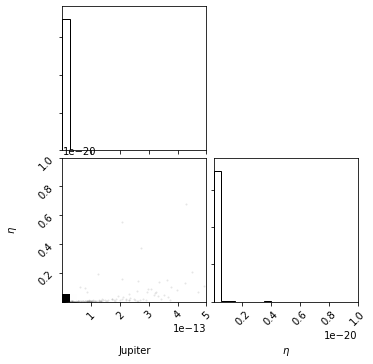

In [9]:
fig_SUN_JUP = corner.corner(flat_SUN_JUP, range = [(0, 5e-13), (0, 1e-20)], labels = ['Jupiter', r'$\eta$']);

In [11]:
samples_SUN_JUP_sat, flat_SUN_JUP_sat = run_MCMC("invisoplanet_detection/data/sun_jup_sat_2_1_1.json", 2, 1, 2)

100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:52<00:00, 95.57it/s]


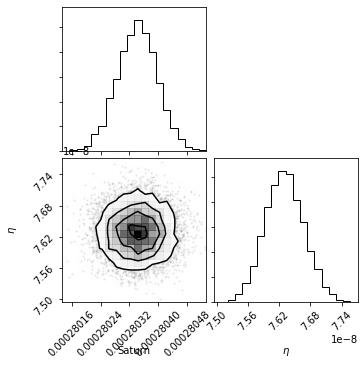

In [12]:
fig_SUN_JUP_sat = corner.corner(flat_SUN_JUP_sat, labels = ['Saturn', r'$\eta$']);

In [17]:
samples_SAT_sun_jup, flat_SAT_sun_jup = run_MCMC("invisoplanet_detection/data/sat_sun_jup_1_2_2.json", 1, 2, 2, init_guess_factor_1 = 50, init_guess_factor_2 = 50, num_iter_MCMC = 10000, num_iter_likelihood = 40000)

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [05:44<00:00, 29.06it/s]


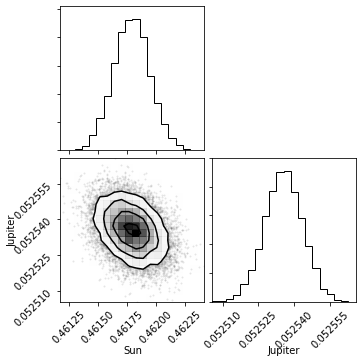

In [18]:
fig_SAT_sun_jup = corner.corner(flat_SAT_sun_jup, labels = ['Sun', 'Jupiter'])

In [3]:
samples_SAT_sun_jup_dif_IC, flat_SAT_sun_jup_dif_IC = run_MCMC("invisoplanet_detection/data/sat_sun_jup_1_2_2.json", 1, 2, 2, init_guess_factor_1 = 50, init_guess_factor_2 = 1, num_iter_MCMC = 10000, num_iter_likelihood = 40000)

Mass 2 list:   0%|                                                                               | 0/9 [00:00<?, ?it/s]


100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [03:08<00:00, 53.19it/s]


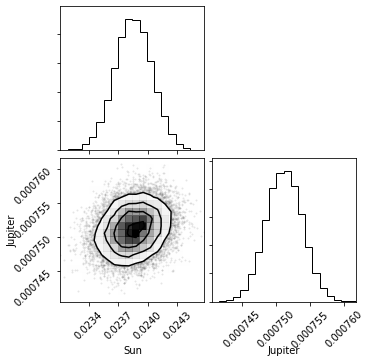

In [9]:
fig_SAT_sun_jup_dif_IC = corner.corner(flat_SAT_sun_jup_dif_IC, labels = ['Sun', 'Jupiter'])

In [6]:
samples_SAT_sun_jup_eta, flat_SAT_sun_jup_eta = run_MCMC("invisoplanet_detection/data/sat_sun_jup_1_2_2.json", 1, 2, 3, num_iter_MCMC = 10000, num_iter_likelihood = 40000, init_guess_factor_1 = 50, init_guess_factor_2 = 50)

Mass 2 list:   0%|                                                                               | 0/9 [00:00<?, ?it/s]


100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [04:05<00:00, 40.74it/s]


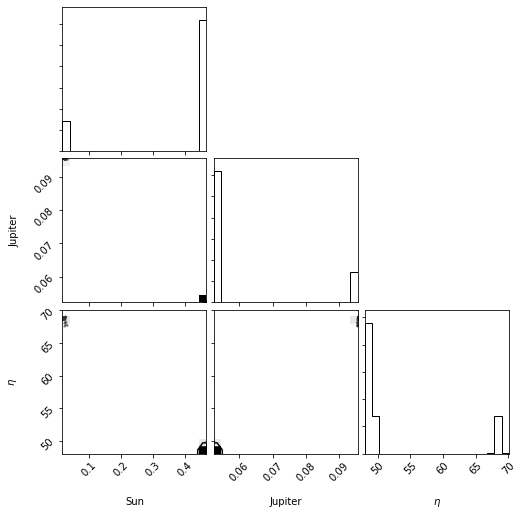

In [8]:
fig_SAT_sun_jup_eta = corner.corner(flat_SAT_sun_jup_eta, labels = ['Sun', 'Jupiter', r'$\eta$'])

INITIAL TESTS WERE RAN STARTING HERE:

In [2]:
# Setup the likelihood object
known_bodies = 2
unknown_bodies = 1
parameters_filename = "invisoplanet_detection/data/sun_jup_2_0_1.json"
max_masses = np.array([1e-3])  #Actual mass x2, or small value if actual mass is 0
surrogate_points = 9

# Optional arguments for Likelihood (these are the default values)
num_iterations = 20_000     
time_step = 0.5
last_n = 100        

# Construct the likelihood object
likelihood_SUN_JUP = Likelihood(known_bodies, unknown_bodies, parameters_filename, max_masses, surrogate_points, num_iterations, time_step, last_n)
 

Mass 1 list: 100%|███████████████████████████████████████████████████████████████████████| 9/9 [00:52<00:00,  5.86s/it]


In [3]:
#Setup the MCMC
#likelihood.log_posterior_variable_eta((guess_masses, eta), x = None, y = None, yerr = None)
num_walker = 16
num_dim = 2
num_iter = 5000
init_pos = np.random.rand(num_walker, num_dim) @ np.array([[10**(-6), 0],[0, 1]])

#Run the MCMC
sampler = emcee.EnsembleSampler(num_walker, num_dim, likelihood_SUN_JUP.log_posterior_variable_eta)
sampler.run_mcmc(init_pos, num_iter, progress=True);

100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:43<00:00, 115.19it/s]


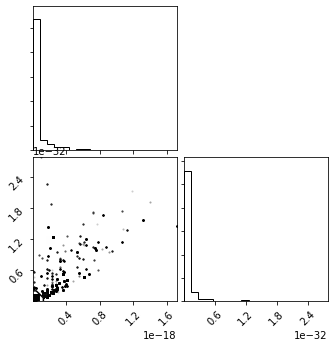

In [15]:
samples = sampler.get_chain()
flat_samples = sampler.get_chain(discard=1000, flat=True)
fig = corner.corner(flat_samples);

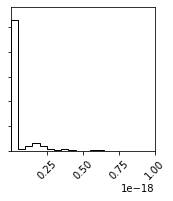

In [38]:
fig = corner.corner(flat_samples[:,0], range = [(0, 1e-18)])

In [32]:
a = np.array([[1,2,3,4],[5,6,7,8]])
print(a[:,0])

[1 5]


In [20]:
#Setup the MCMC
#likelihood.log_posterior_variable_eta((guess_masses, eta), x = None, y = None, yerr = None)
num_walker = 16
num_dim = 1
num_iter = 5000
init_pos = 10**(-8) * np.random.randn(num_walker, 1)

likelihood_SUN_JUP.set_eta(1)

#Run the MCMC
sampler = emcee.EnsembleSampler(num_walker, num_dim, likelihood_SUN_JUP.log_posterior)
sampler.run_mcmc(init_pos, num_iter, progress=True);

  0%|                                                                                         | 0/5000 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\emcee\moves\red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [01:26<00:00, 57.49it/s]


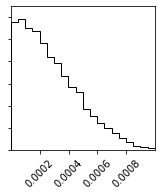

In [21]:
samples = sampler.get_chain()
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
fig = corner.corner(flat_samples);